In [ ]:
import numpy as np
import pandas as pd

# Read in the .csv file

data = pd.read_csv('Clean Data.csv')

#Drop the time stamps from the dataset as they don't contribute to the average price output

data = data.drop(['Date - MST'], axis= 1)

# Isolate the Avg Price column to be the target variable 

data_y = data['Avg. Price']

data_X = data.drop(['Avg. Price', 'Avg. Spark Spread'], axis= 1)

#print(data_X.dtypes)

#print(data_y.dtypes)

data_X.shape




(26304, 90)

In [16]:
# Drop Columns that don't add to the price estimation or are double counting the data such as 
# percentages when the numerator and denominator are also in the dataset.

#Drop columns using the index of the column rather than the column name for clarity of code. 

drop_columns = [0, 1, 2, 7, 8, 9, 10, 15, 16, 17, 18, 23, 24, 25, 26, 31, 32, 33, 34, 39, 40, 41, 42,
                47, 48, 49, 50, 55, 56, 57, 58, 63, 64, 65, 66, 71, 72, 73, 74, 79, 80, 81, 82, 87]

data_X = data_X.drop(data_X.columns[drop_columns], axis=1)

#Check for missing/null data

data_X.isnull().sum()

#Fill missing coal data with 0's. Coal is no longer used for power generation in Alberta so values of 0 are accurate.

data_X = data_X.fillna(0)

#Double check the dropping and filling worked. 

data_X.isnull().sum()

data_X.shape

(26304, 46)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#First split data into train and test before scaling so the target variable is not impacted.

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size= 0.2, random_state= 0)

#Use a standard scaler to scale data about the norm. A RobustScaler was considered but outer quartile data may still be relevant in this case so Standard was chosen. 
scale_data = StandardScaler()

#Apply the scaling to the X training set

X_train_scale = scale_data.fit_transform(X_train)

# Apply only the transformation from above to the test so that it is scaled but there is no learning done from the test set to influence the outcome.

X_test_scale = scale_data.transform(X_test)

In [18]:
# Linear Model 1 - Linear Regression

# Use Scaled data

# It is assumed that the performance of this model will not be great as the data is not linear. This model was chosen as a starting point and for comparison reasons. 

from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train_scale, y_train)

# Find training and validation score to determine how effective this LinerRegression model is

print("Training score: {:.2f}".format(linreg.score(X_train_scale, y_train)))
print("Validation score: {:.2f}".format(linreg.score(X_test_scale, y_test)))

# Determine regression specific scores to evaluate the model:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = linreg.predict(X_test_scale)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Training score: 0.49
Validation score: 0.50
Mean Squared Error: 15888.967967050432
R² Score: 0.5004322849815905


In [20]:
# Linear Model #2 - Ridge Regression Model

# Use a better linear model to see if there is much improvement to the scores. 

# Ridge was chosen over Lasso, so no features were reduced to zero.

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Set up a range of alpha values to try for Ridge Regression to tune the hyperparameter
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridgereg = Ridge()

# Use grid search to determine the best alpha value
grid_search = GridSearchCV(ridgereg, param_grid, cv=5)
grid_search.fit(X_train_scale, y_train)

print("Best Alpha:", grid_search.best_params_['alpha'])

# Use the best alpha value to calculate regression scores
best_ridgereg = grid_search.best_estimator_
print("Best Ridge Training R²:", best_ridgereg.score(X_train_scale, y_train))
print("Best Ridge Validation R²:", best_ridgereg.score(X_test_scale, y_test))

Best Alpha: 0.01
Best Ridge Training R²: 0.4882343535369086
Best Ridge Validation R²: 0.49977668647979834


In [23]:
#Non-linear Model - Random Forest Regressor

# Doesn't require scaled data

#Expected to have a much better outcome as the data is non-linear

from sklearn.ensemble import RandomForestRegressor

randforestreg = RandomForestRegressor(random_state=1)

#Use the unscaled training data
randforestreg.fit(X_train, y_train)

# Evaluate
print("Random Forest Training R²:", randforestreg.score(X_train, y_train))
print("Random Forest Validation R²:", randforestreg.score(X_test, y_test))

Random Forest Training R²: 0.9791650854432387
Random Forest Validation R²: 0.8580076303013201


In [24]:
#Tune Hyperparameters and run again to observe any improvement.

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=1), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
print("Tuned Training R²:", best_rf.score(X_train, y_train))
print("Tuned Validation R²:", best_rf.score(X_test, y_test))

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Training R²: 0.9797862653555465
Tuned Validation R²: 0.8581390311174664


In [26]:
# Make predictions

y_pred = grid_search.best_estimator_.predict(X_test)

# Save to CSV
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

output_df.head()

,Actual,Predicted
25666,16.47,20.96390
11090,35.17,36.69755
5219,62.86,72.02835
8640,325.36,257.42765
9342,79.35,72.32665


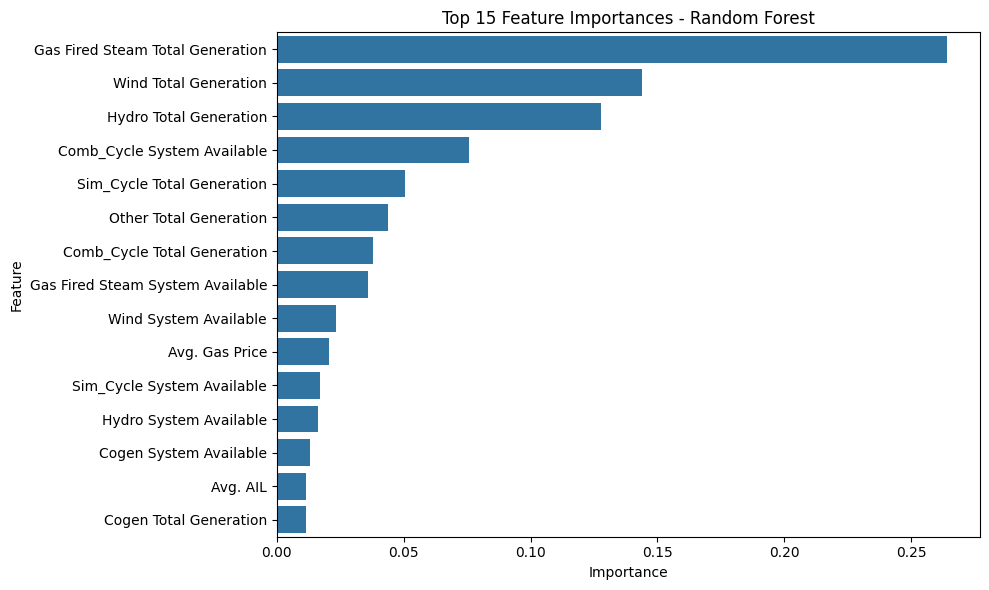

In [27]:
# Graphs

import matplotlib.pyplot as plt
import seaborn as sns

importances = grid_search.best_estimator_.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

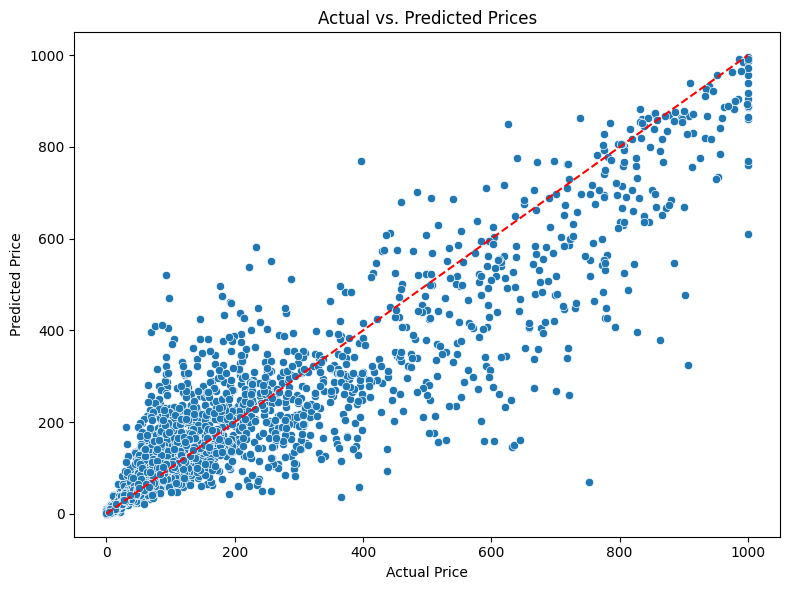

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.tight_layout()
plt.show()

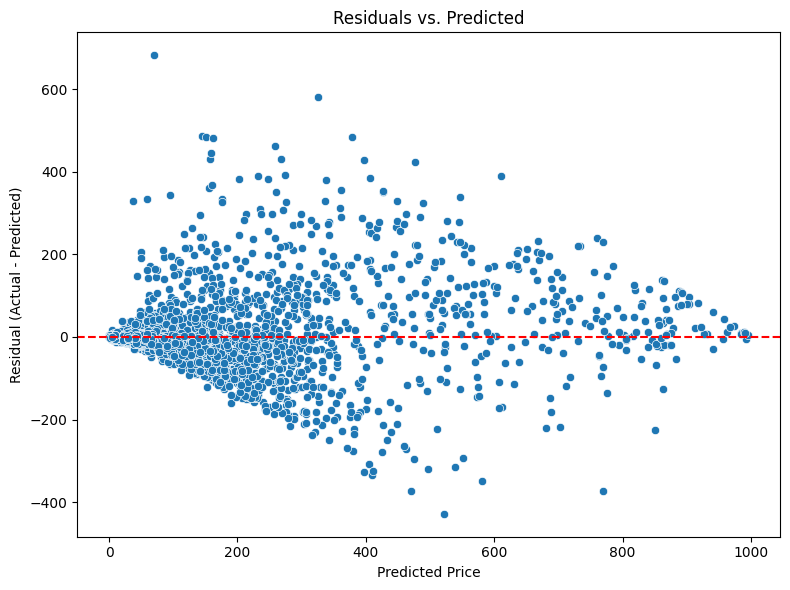

In [29]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs. Predicted')
plt.tight_layout()
plt.show()

In [30]:
import numpy as np

avg_pred = np.mean(y_pred)
avg_actual = np.mean(y_test)

print("Average Predicted Price: {:.2f}".format(avg_pred))
print("Average Actual Price: {:.2f}".format(avg_actual))

Average Predicted Price: 120.70
Average Actual Price: 120.16
